# Load cache


In [2]:
import cache_magic

%cache magic is now registered in ipython


# Data download

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lux 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/olist_order_payments_dataset.csv
./data/olist_sellers_dataset.csv
./data/olist_order_reviews_dataset.csv
./data/olist_order_items_dataset.csv
./data/olist_orders_dataset.csv
./data/olist_geolocation_dataset.csv
./data/olist_products_dataset.csv
./data/olist_customers_dataset.csv
./data/product_category_name_translation.csv


In [4]:
customers = pd.read_csv("./data/olist_customers_dataset.csv")
sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
reviews = pd.read_csv("./data/olist_order_reviews_dataset.csv")
items = pd.read_csv("./data/olist_order_items_dataset.csv")
products = pd.read_csv("./data/olist_products_dataset.csv")
geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")
category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
orders = pd.read_csv("./data/olist_orders_dataset.csv")
order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")

## Merge datasets

In [5]:
datasets = [customers, sellers, reviews, items, products, geolocation, category_name_translation, orders, order_payments]

In [6]:
df = orders.merge(items, on="order_id").merge(products, on = "product_id").merge(sellers, on="seller_id").merge(customers, on="customer_id")

In [7]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

# Data cleaning

In [8]:
#date_cols = [order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp", "order_delivered_customer_date"]

df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

df['expected_delivery_timedelta'] = pd.to_numeric(df['order_estimated_delivery_date']- df["order_purchase_timestamp"])
df['delivery_time'] = pd.to_numeric(df["order_delivered_customer_date"] - df['order_purchase_timestamp'])

df['product_volume'] = df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]

df["same_city"] = df["customer_city"] == df["seller_city"]
df["same_state"] = df["customer_state"] == df["seller_state"]

In [9]:
#df.drop(["expected_delivery_timedelta"], axis = 1, inplace=True)

In [10]:
df

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/vislib/altair/Histogram.py:47: RuntimeWarning:overflow encountered in long_scalars


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [11]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

## Feature extraction

In [12]:
unique_orders_count = df.groupby(["customer_id"])["order_id"].count() # Count unique orders
nof_moest_popular_sales = df.groupby(["customer_id"])["seller_id"].agg(lambda x:x.value_counts()[0]) # Number of orders from most popular sellers
max_sale = df.groupby(["customer_id"])["price"].max() # Most money spent on single order
median_sale = df.groupby(["customer_id"])["price"].median() # Median money spent on orders
sum_sale = df.groupby(["customer_id"])["price"].sum() # Median money spent on orders

median_volume = df.groupby(["customer_id"])["product_volume"].median() # Median volume of products in orders
max_volume = df.groupby(["customer_id"])["product_volume"].max() # Median money spent on orders

average_delivery_time = df.groupby(["customer_id"])["delivery_time"].max() # Average delivery time
average_expected_delivery_time = df.groupby(["customer_id"])["expected_delivery_timedelta"].max() # Average delivery time


unique_orders_count.name = "unique_orders_count"
nof_moest_popular_sales.name = "nof_moest_popular_sales"
max_sale.name = "max_sale"
median_sale.name = "median_sale"
sum_sale.name = "sum_sale"
median_volume.name = "median_volume"
average_delivery_time.name = "average_delivery_time"
average_expected_delivery_time.name = "average_expected_delivery_time"

In [13]:
%cache customers2 = customers.set_index("customer_id")

loading cached value for variable 'customers2'. Time since pickling  4 days, 18:16:47.279902


In [14]:
%cache df2 = customers2.join([unique_orders_count, nof_moest_popular_sales, max_sale, median_sale, sum_sale, median_volume, average_delivery_time,average_expected_delivery_time],  how="outer")

creating new value for variable 'df2'


In [15]:
df2[df2["unique_orders_count"] > 1]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [16]:
cat_attributes = ["customer_city", "customer_state"]
num_attributes = ["unique_orders_count", "nof_moest_popular_sales", "max_sale", "median_sale", "sum_sale", "median_volume", "average_delivery_time","average_expected_delivery_time"]

In [17]:
df2['average_expected_delivery_time'] = df2['average_expected_delivery_time']
df2['average_delivery_time'] = df2['average_delivery_time']

In [18]:
%cache df2 = df2.fillna(df2.mean())

creating new value for variable 'df2'


In [19]:
df2.info()

<class 'lux.core.frame.LuxDataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              99441 non-null  object 
 1   customer_zip_code_prefix        99441 non-null  int64  
 2   customer_city                   99441 non-null  object 
 3   customer_state                  99441 non-null  object 
 4   unique_orders_count             99441 non-null  float64
 5   nof_moest_popular_sales         99441 non-null  float64
 6   max_sale                        99441 non-null  float64
 7   median_sale                     99441 non-null  float64
 8   sum_sale                        99441 non-null  float64
 9   median_volume                   99441 non-null  float64
 10  average_delivery_time           99441 non-null  float64
 11  average_expected_delivery_time  99441 no

In [20]:
df2.groupby("customer_city")["customer_state"].value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [21]:
df2.customer_city.nunique()

4119

In [22]:
groupby_col="customer_city"

In [23]:
other_countes = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[1000:,:].reset_index()[groupby_col].array

In [24]:
df2.loc[df2.customer_city.isin(other_countes), "customer_city"] = "other"

In [25]:
df2.customer_city.nunique()

1001

# Pipeline

In [146]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_attributes),
        ('cat', OneHotEncoder(), cat_attributes),
])
df_prepared = pipeline.fit_transform(df2)
df_prepared

<99441x1036 sparse matrix of type '<class 'numpy.float64'>'
	with 992085 stored elements in Compressed Sparse Row format>

In [43]:
df_prepared[:,8:].toarray().shape

(99441, 1028)

## Autoencoding sparse features

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

encoding_dim = 10

input_vec = keras.Input(shape=(1028,))

# Autoencoder
encoded = layers.Dense(encoding_dim, activation='relu')(input_vec)

decoded = layers.Dense(1028, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_vec, decoded)

## Encoder and decoder

In [41]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_vec, encoded)

# This is our encoded (10-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [42]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [64]:
from sklearn.model_selection import train_test_split

In [134]:
X_train, X_test = train_test_split(df_prepared[:,8:].toarray(), test_size=0.2)

In [50]:
X_train.shape

(79552, 1028)

In [51]:
X_test.shape

(19889, 1028)

In [145]:
df2.fillna(0, inplace=True)

In [66]:
from sklearn.metrics import r2_score

In [68]:
X_pred = decoder.predict(encoder.predict(X_test))

In [69]:
r2_score(X_test, X_pred)

0.3356247873011441

## Train encoders

In [53]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

2021-08-13 11:46:19.542185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-13 11:46:19.561632: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2994380000 Hz


Epoch 1/50


2021-08-13 11:46:19.855636: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 41/311 [==>...........................] - ETA: 1s - loss: 0.6765

2021-08-13 11:46:20.608684: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


311/311 [==============================] - 3s 5ms/step - loss: 0.3186 - val_loss: 0.0520
Epoch 2/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0270 - val_loss: 0.0161
Epoch 3/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0112
Epoch 4/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 5/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 6/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 7/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 8/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 9/50
311/311 [==============================] - 1s 5ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 10/50
311/311 [==============================] - 2s 5ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 11/5

In [39]:
len(num_attributes)

8

In [147]:
n = df_prepared[:,:8].toarray()

In [148]:
c = encoder.predict(df_prepared[:,8:].toarray())

In [149]:
import lux
df3 = np.concatenate((n,c), axis=1)

In [79]:
df3.shape

(99441, 18)

# HDBSCAN

In [80]:
import hdbscan
%cache clusterer = hdbscan.HDBSCAN(min_cluster_size=600, min_samples=80, cluster_selection_epsilon=0.6)

creating new value for variable 'clusterer'


In [81]:
#clusterer.fit(df3[np.random.choice(df3.shape[0],50000, replace=False),:])
%cache clusterer = clusterer.fit(df3)

creating new value for variable 'clusterer'


In [82]:
max(clusterer.labels_)

32

<AxesSubplot:ylabel='Count'>

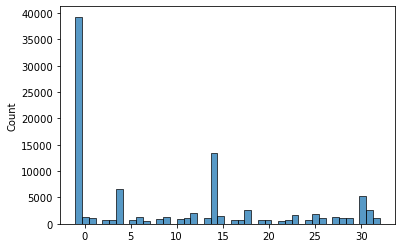

In [83]:
import seaborn as sns
sns.histplot(clusterer.labels_)

# UMAP

In [84]:
import umap

In [85]:
import umap.plot

In [151]:
mapper = umap.UMAP(densmap=True).fit(df3)

<AxesSubplot:>

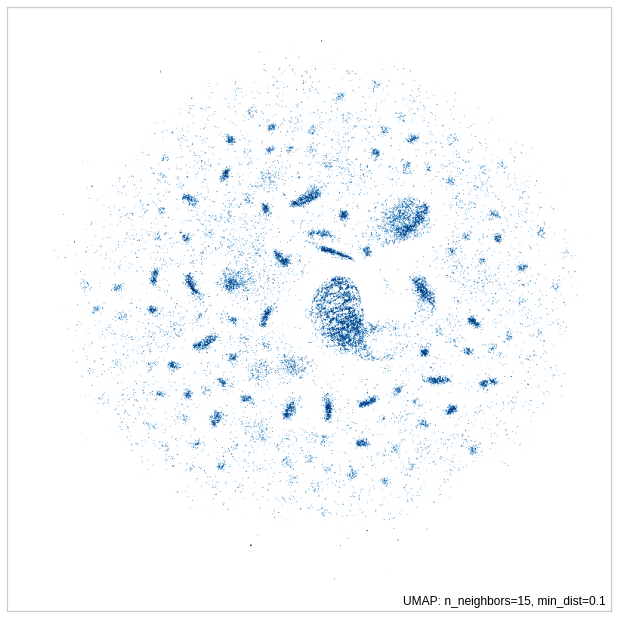

In [152]:
umap.plot.points(mapper)

## HDBSCAN viz

<AxesSubplot:>

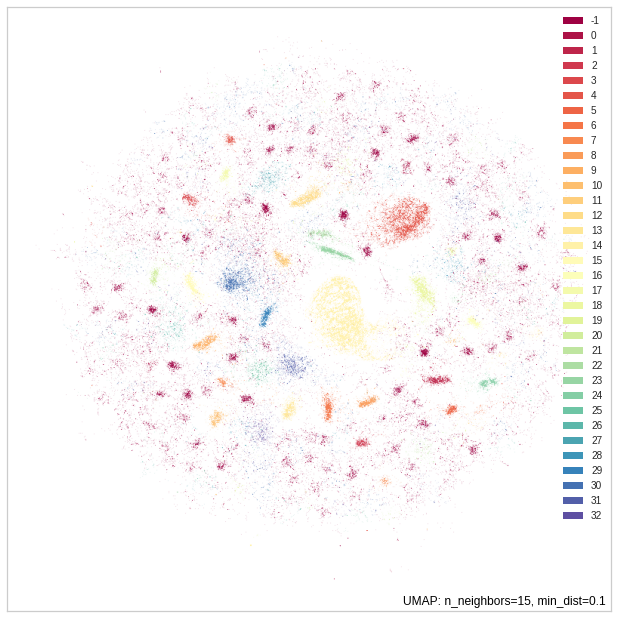

In [153]:
umap.plot.points(mapper, labels=clusterer.labels_)

## UMAP -> HDBSCAN viz

In [154]:
clusterer2 = hdbscan.HDBSCAN(min_cluster_size=300)
clusterer2 = clusterer2.fit(mapper.embedding_)

<AxesSubplot:>

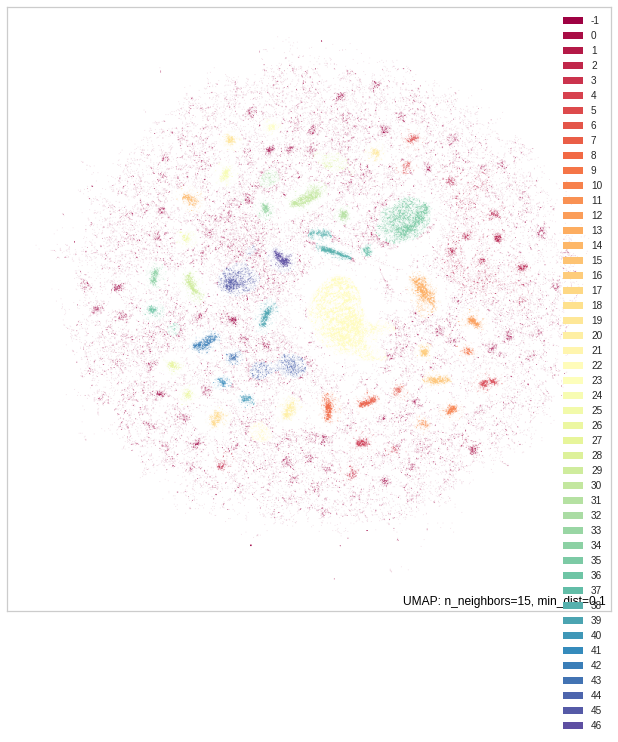

In [155]:
umap.plot.points(mapper, labels=clusterer2.labels_)

In [37]:
df3.data

In [38]:
df3.shape

(99441, 57)

In [39]:
df3

array([[-0.26425169, -0.24920597, -0.00859807, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.85036823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.06969927, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.26425169, -0.24920597, -0.46942634, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597,  2.94528026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597, -0.58993616, ...,  0.        ,
         1.        ,  0.        ]])

# KMEANS

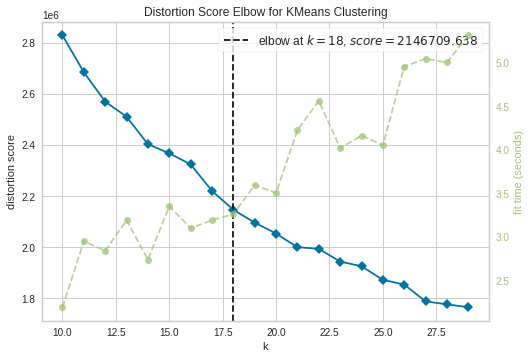

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [91]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()

visualizer = KElbowVisualizer(model, k=(10,30), timings=True)
visualizer.fit(df3)
visualizer.show()

In [92]:
X = df3
kmeans = KMeans(n_clusters=18, random_state=0, copy_x=False).fit(X)

In [93]:
kmeans.labels_

array([ 8, 13,  2, ..., 16, 14, 13], dtype=int32)

<AxesSubplot:ylabel='Count'>

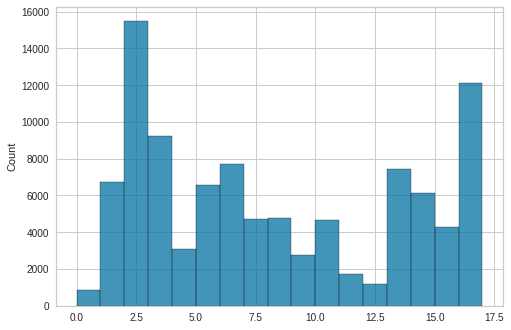

In [94]:
sns.histplot(kmeans.labels_, bins=max(kmeans.labels_))

## Kmeans viz

<AxesSubplot:>

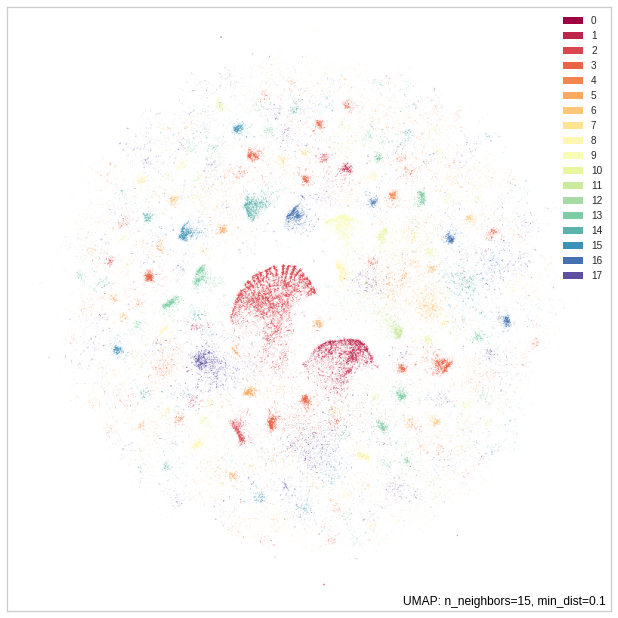

In [95]:
umap.plot.points(mapper, labels=kmeans.labels_)

## UMAP -> KMEANS viz

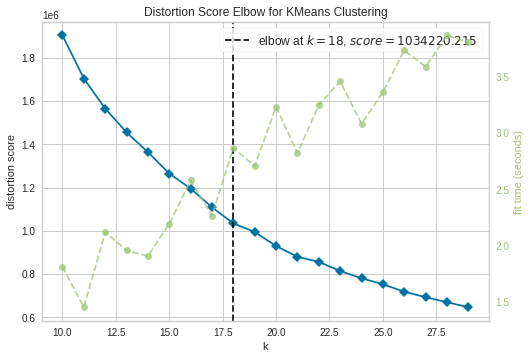

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
visualizer = KElbowVisualizer(model, k=(10,30), timings=True)
visualizer.fit(mapper.embedding_)
visualizer.show()

In [100]:
kmeans2 = KMeans(n_clusters=18, random_state=0, copy_x=False).fit(mapper.embedding_)

<AxesSubplot:>

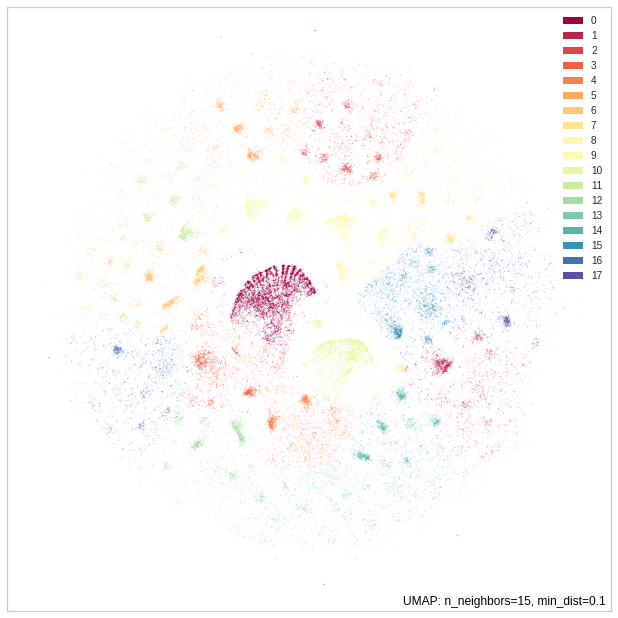

In [101]:
umap.plot.points(mapper, labels=kmeans2.labels_)

In [156]:
points = mapper.embedding_

In [46]:
points[:,0]

array([ 1.843174  , -7.1535196 ,  6.527419  , ...,  8.987339  ,
       -0.89191645, 10.583327  ], dtype=float32)

In [47]:
df2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [48]:
#umap.plot.connectivity(mapper, show_points=True, labels=kmeans.labels_)

In [49]:
#umap.plot.connectivity(mapper, edge_bundling='hammer')

In [103]:
import seaborn as sns

In [104]:
points

array([[ 18.36795  ,   4.7941213],
       [-10.682985 ,   3.6860495],
       [ -3.7881699,   2.6784575],
       ...,
       [ 17.093094 ,   3.4298182],
       [-10.372317 ,  -6.2268066],
       [ -3.4041688,  19.72585  ]], dtype=float32)

In [157]:
df2["x"] = points[:,0]
df2["y"] = points[:,1]

In [106]:
df2['y']

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [107]:
df2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

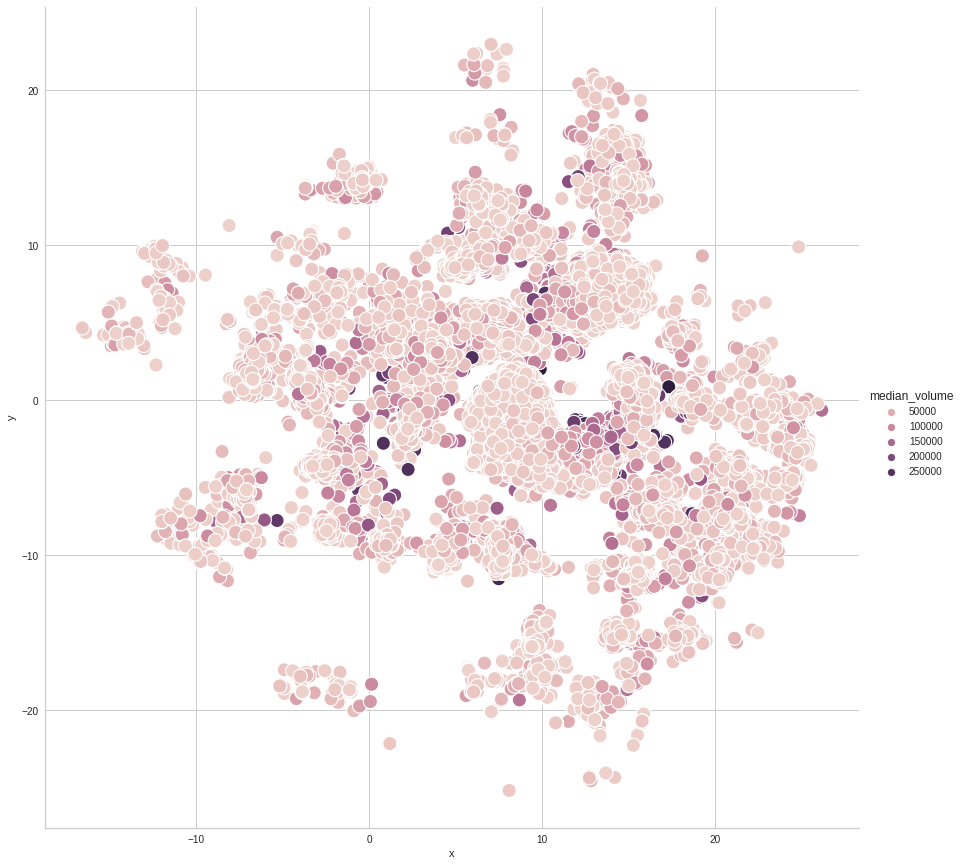

In [161]:
countries = df2.groupby('customer_city').count().sort_values('customer_state', ascending=False).iloc[0:10,:].reset_index()['customer_city'].array
sns.relplot(
    data = df2.loc[df2['customer_city'].isin(countries)],
    x = "x",
    y = "y",
    hue = 'median_volume',
    height = 12,
    s=200)

In [127]:
df2["average_delivery_time"] = np.log(df2["average_delivery_time"] + 2.73)
df2["median_sale"] = np.log(df2["median_sale"] + 2.73)

<AxesSubplot:xlabel='average_delivery_time', ylabel='Count'>

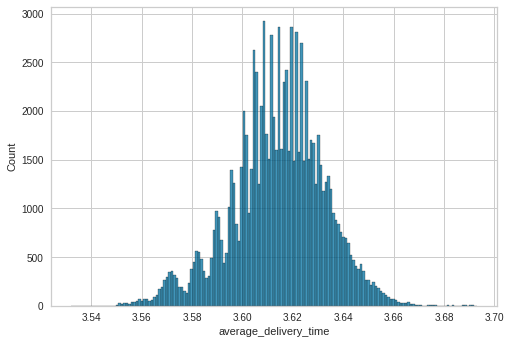

In [126]:
sns.histplot(data=df2, x="average_delivery_time")

<AxesSubplot:xlabel='median_sale', ylabel='Count'>

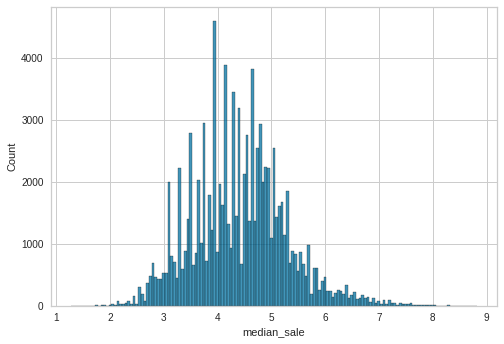

In [128]:
sns.histplot(data=df2, x="median_sale")

<AxesSubplot:xlabel='x', ylabel='y'>

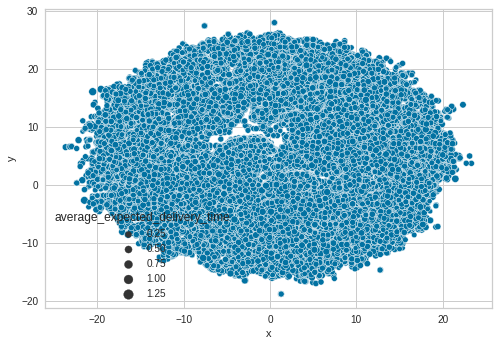

In [117]:
sns.scatterplot(
    data = df2,
    x = "x",
    y = "y",
    size = 'average_expected_delivery_time')

In [56]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y'],
      dtype='object')

In [67]:
%cache smapper = umap.UMAP().fit_transform(X, kmeans.labels_)

creating new value for variable 'smapper'


NameError: name 'smapper' is not defined

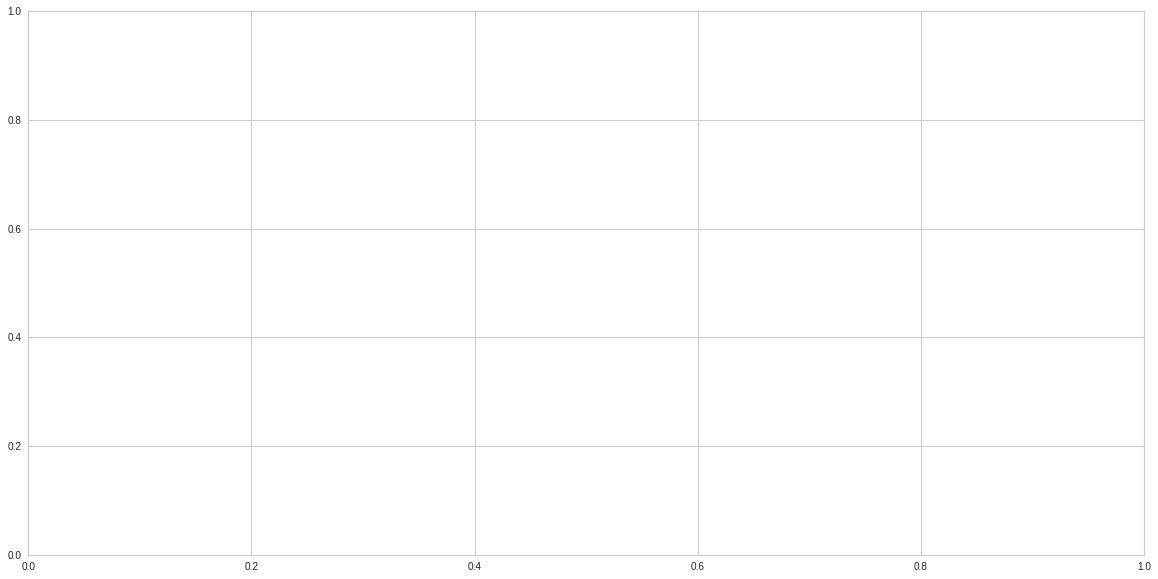

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=smapper[:,0], y=smapper[:,1], hue=kmeans.labels_, ax=ax, palette=sns.color_palette("icefire", 21))

<AxesSubplot:>

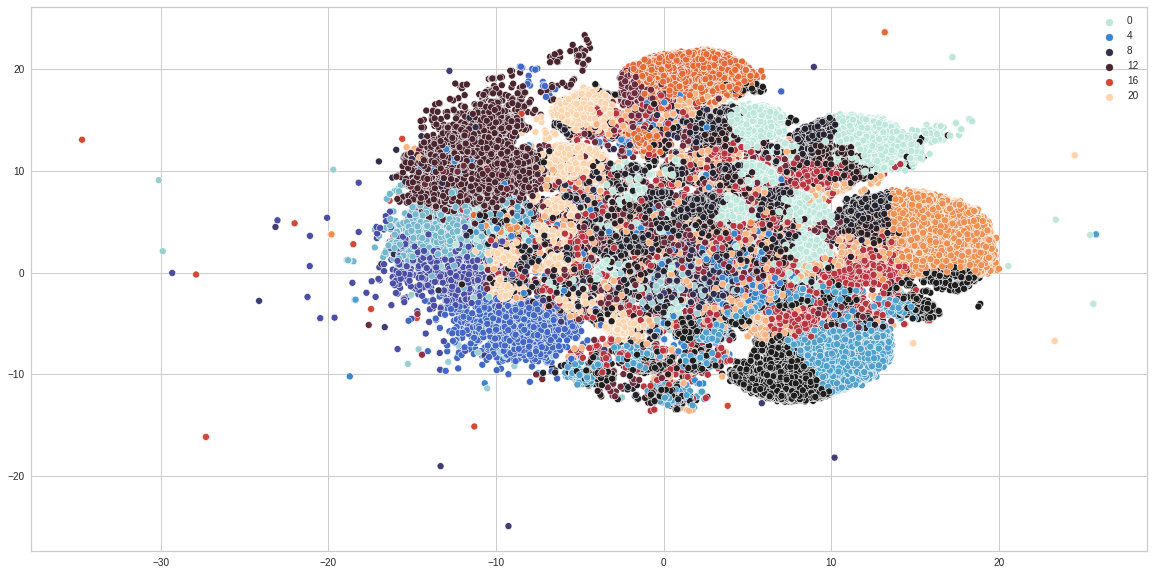

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=kmeans.labels_, ax=ax, palette=sns.color_palette("icefire", as_cmap=True))

In [71]:
df2['x1'] = smapper[:,0]
df2['y1'] = smapper[:,1]

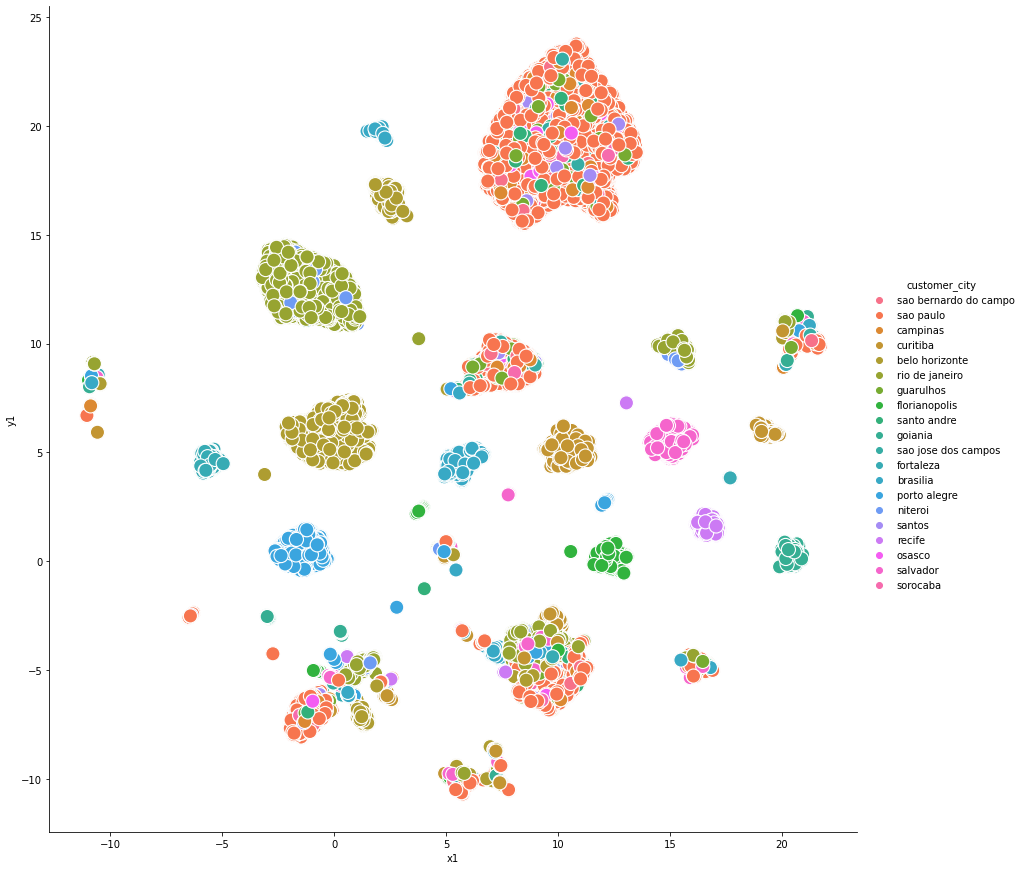

In [74]:
groupby_col="customer_city"

countries = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[0:20,:].reset_index()[groupby_col].array

sns.relplot(
    data = df2.loc[df2[groupby_col].isin(countries)],
    x = "x1",
    y = "y1",
    hue = groupby_col,
    height = 12,
    s=200)

In [76]:
df2.loc[df2[groupby_col].isin(countries)]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [73]:
import sklearn
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)

In [74]:
outlier_scores

array([1, 1, 1, ..., 1, 1, 1])

In [75]:
df2['outlier'] = outlier_scores

In [76]:
df2.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

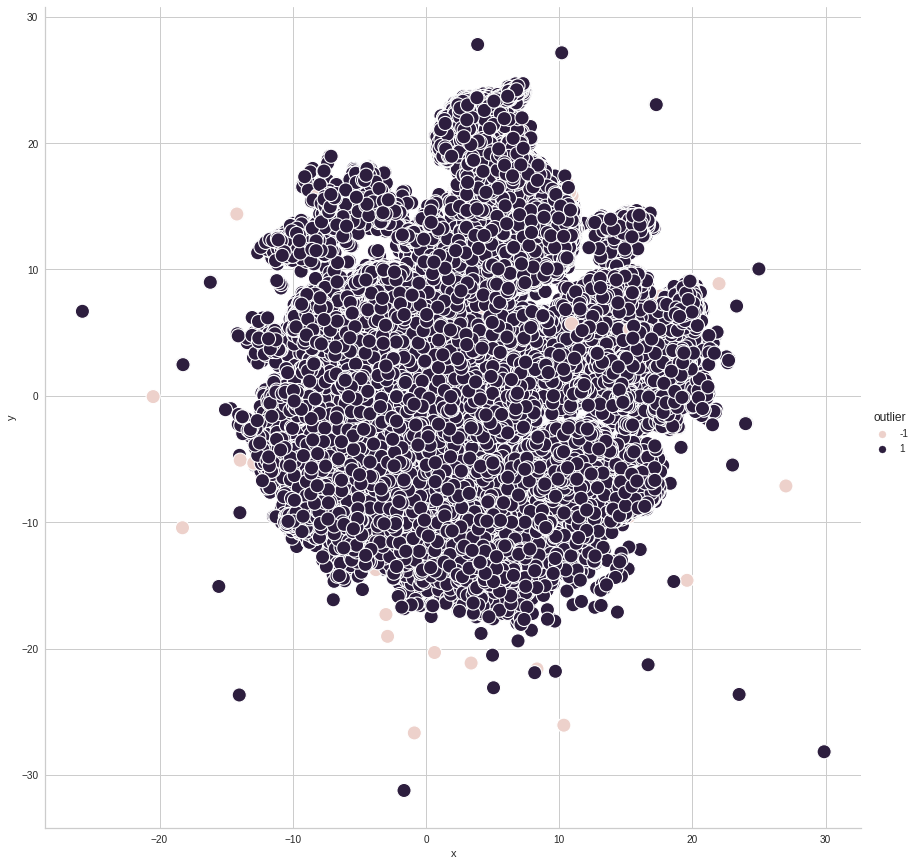

In [77]:
sns.relplot(
    data = df2,
    x = "x",
    y = "y",
    hue = "outlier",
    height = 12,
    s=200)

In [78]:
df.info(0)

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [79]:
df4 = df.merge(df2, on="customer_unique_id")

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='product_width_cm'>

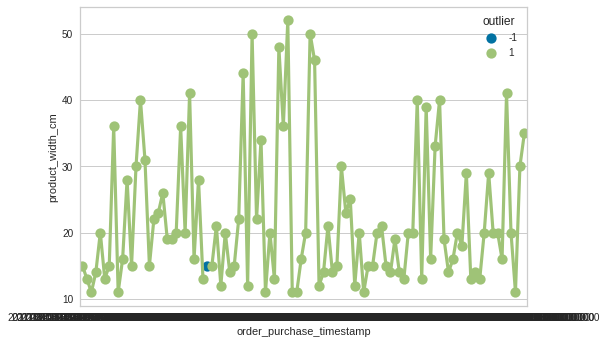

In [80]:
sns.pointplot(x="order_purchase_timestamp", y="product_width_cm", data=df4.sample(100), hue='outlier')

<AxesSubplot:xlabel='price'>

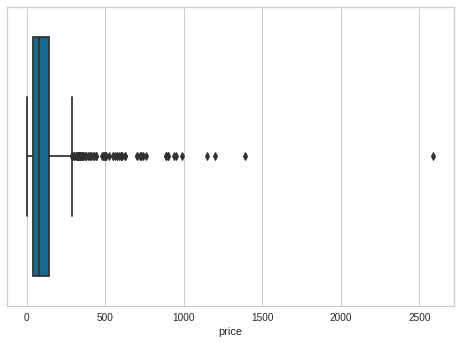

In [81]:
sns.boxplot(x="price", data=df.sample(1000))

<AxesSubplot:xlabel='product_volume'>

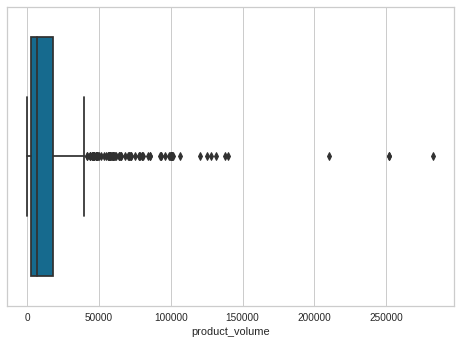

In [82]:
sns.boxplot(x="product_volume", data=df.sample(1000))

# Analizing clusters

In [162]:
df2["cluster"] = kmeans.labels_

In [84]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y',
       'outlier', 'cluster'],
      dtype='object')

<AxesSubplot:xlabel='cluster', ylabel='max_sale'>

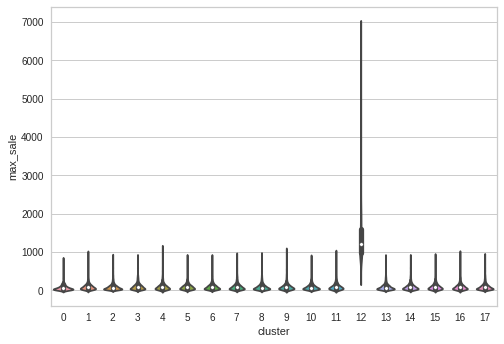

In [163]:
sns.violinplot(data=df2,x="cluster", y="max_sale")

In [164]:
# For all float columns
cols = df2.columns[df2.dtypes == "float64"]

In [165]:
import matplotlib.pyplot as plt
from pylab import *

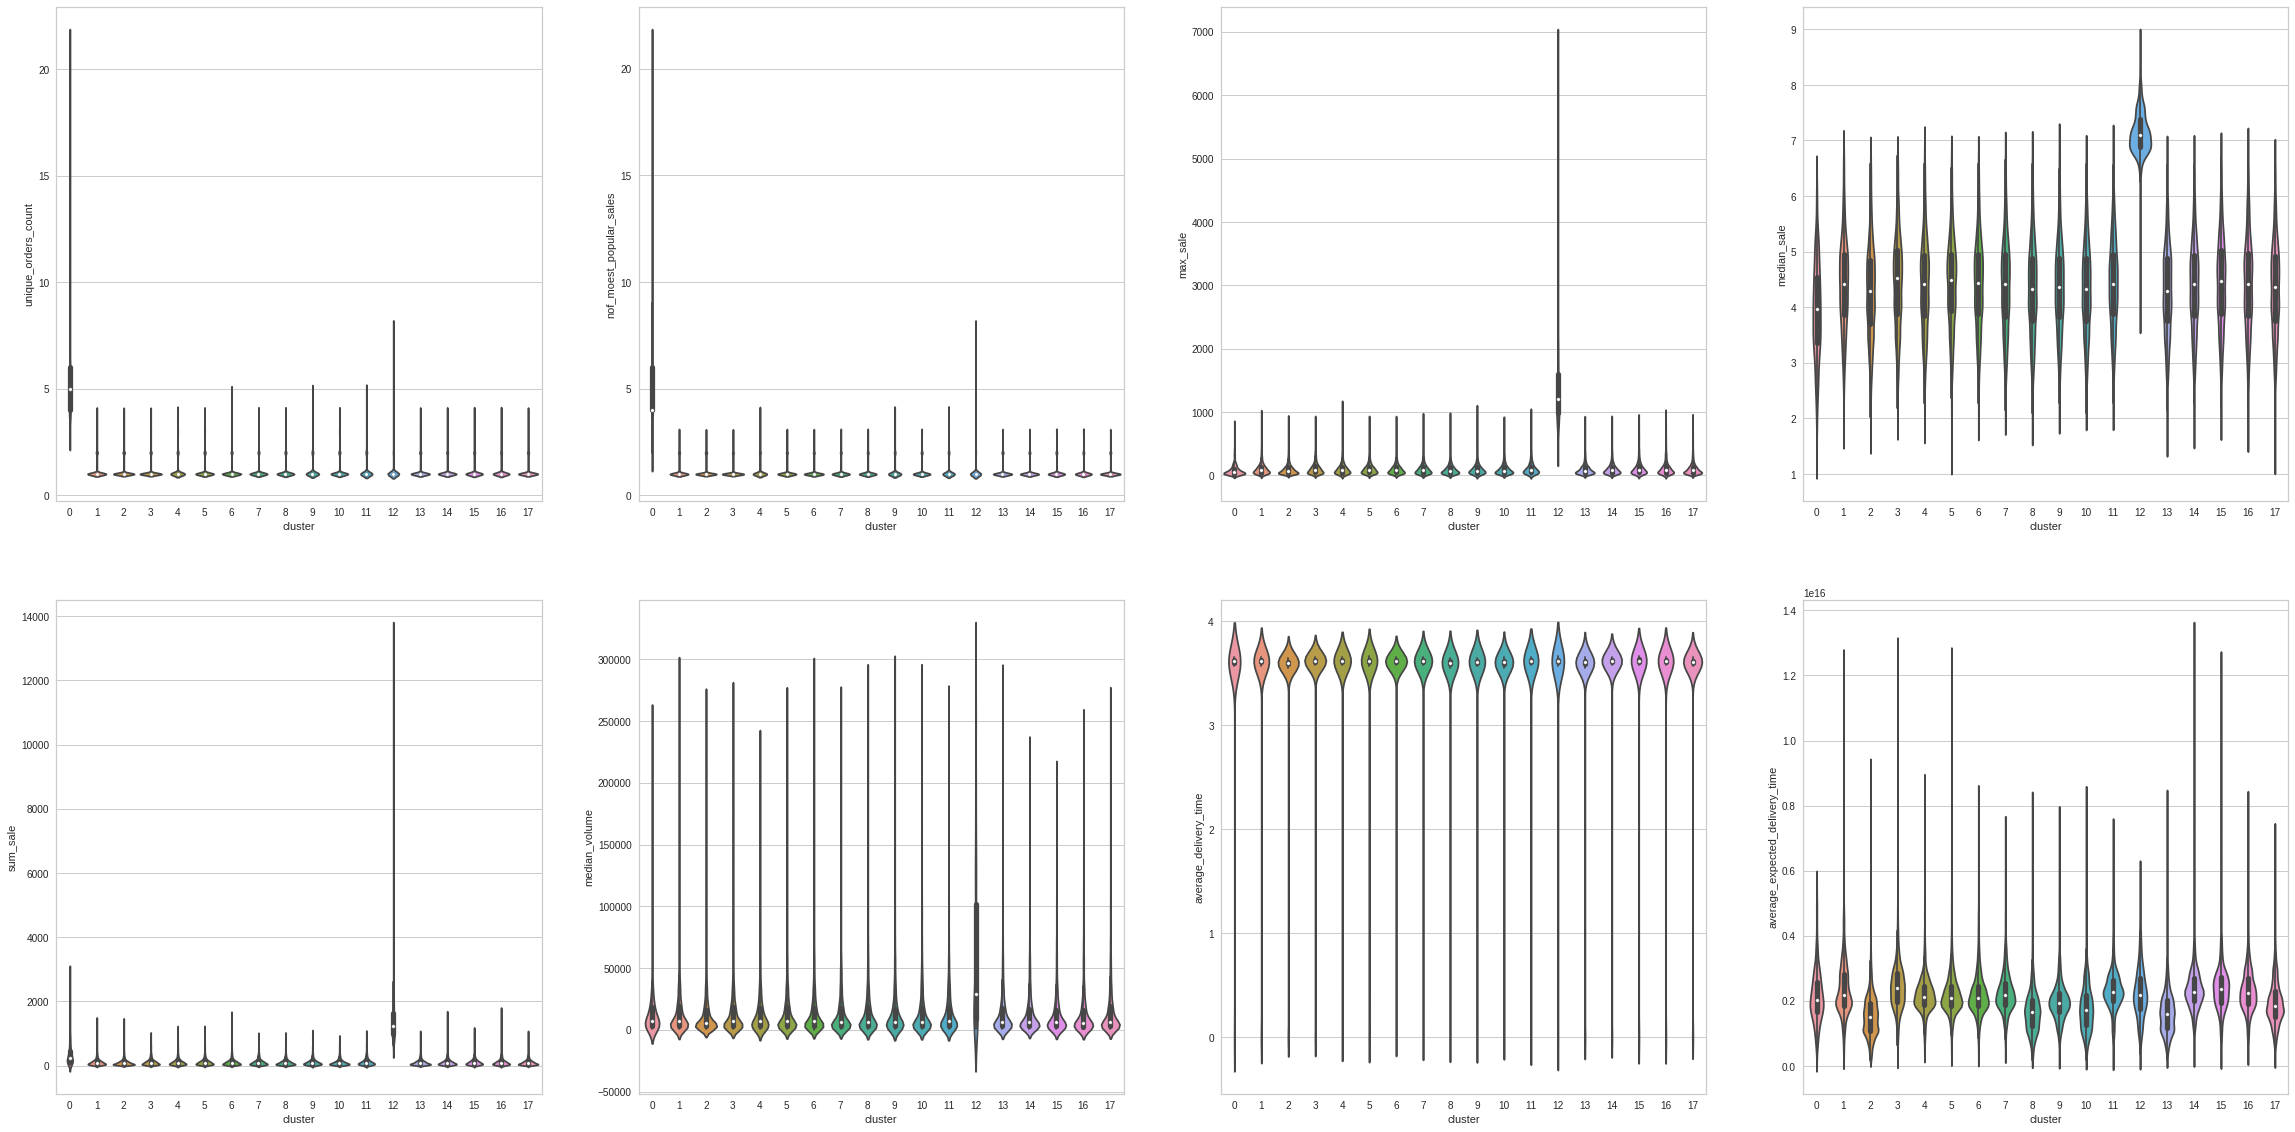

In [166]:
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(40,20))
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(cols[i]))
    sns.violinplot(data=df2,x="cluster", y=cols[i], ax=ax)

In [176]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y',
       'cluster'],
      dtype='object')

In [179]:
df2.groupby(["cluster","customer_state"]).count().sort_values("customer_unique_id").groupby(level=0).tail(1)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [188]:
df2.groupby(["cluster","customer_city"]).count().sort_values("customer_unique_id").groupby(level=0).tail(1)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [189]:
df = df2

# Frequency piecharts

In [265]:
matplotlib.rcParams.update({'font.size': 22})

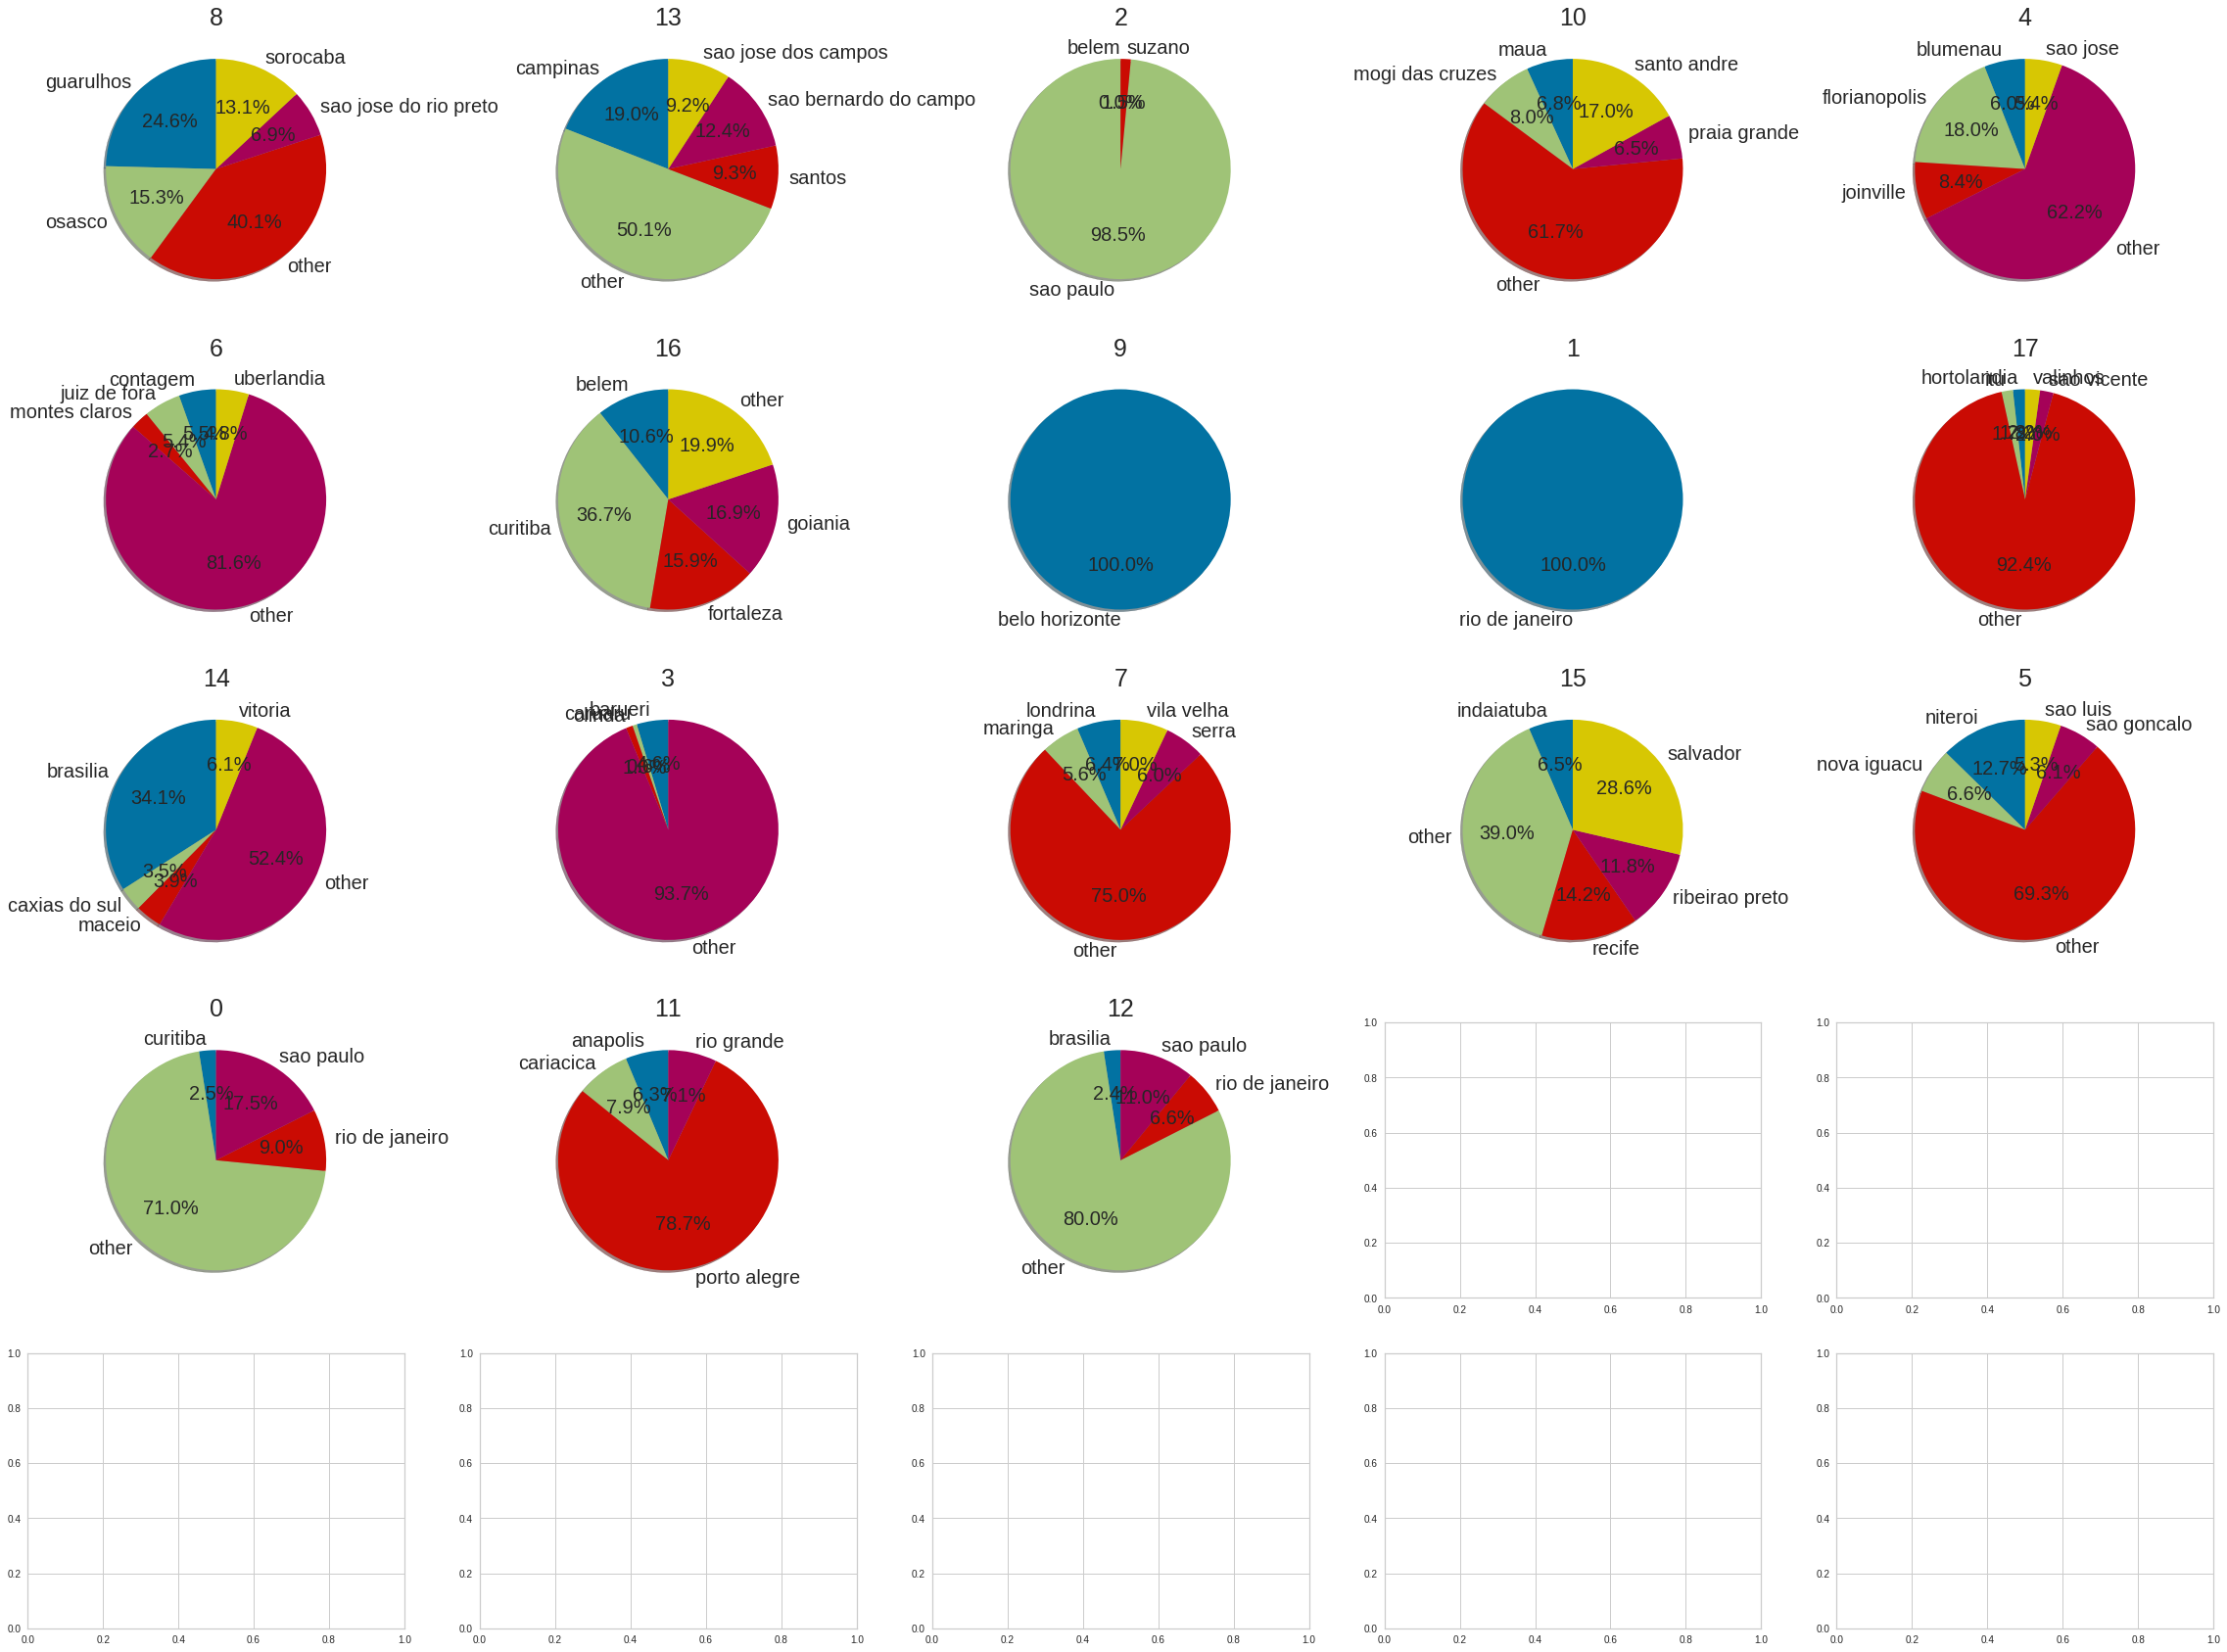

In [277]:
import matplotlib.pyplot as plt
from math import ceil

cluster_col = "cluster"
group_by = "customer_city"
n_first = 4
clusters = df[cluster_col].unique()
nclusters = len(clusters)

# Plot 
fig1, axs = plt.subplots(ceil(sqrt(nclusters)),ceil(sqrt(nclusters)), figsize=(40,30))
axs = axs.flatten()

for i, cluster in enumerate(clusters):
    # Locate all data in cluster, then get n_first most popular entries in group_by. Everything else mark as "other".
    data = df.loc[df[cluster_col] == cluster,:].copy()

    other = data.groupby(group_by).count().sort_values(data.columns[0], ascending=False).iloc[n_first:,:].reset_index()[group_by].array
    data.loc[data[group_by].isin(other), group_by] = "other"

    # Extract data and labels
    data = data.groupby(groupby_col).count().iloc[:,0]

    labels = data.index.to_numpy()
    data = data.to_numpy()


    axs[i].pie(data, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90,  textprops={'fontsize': 20})
    
    axs[i].set_title(str(cluster), fontsize=25)

plt.show()

In [23]:
other_countes = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[1000:,:].reset_index()[groupby_col].array

In [24]:
df2.loc[df2.customer_city.isin(other_countes), "customer_city"] = "other"

In [195]:
clusters

array([ 8, 13,  2, 10,  4,  6, 16,  9,  1, 17, 14,  3,  7, 15,  5,  0, 11,
       12], dtype=int32)

In [187]:
df2.groupby(["cluster","customer_city"]).count().sort_values("customer_unique_id").groupby(level=0).tail(3).sort_values("cluster")

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [90]:
df2.mean()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [91]:
# Author: YousefGh
# Source: https://github.com/YousefGh/kmeans-feature-importance

from sklearn.cluster import KMeans
import numpy as np


class KMeansInterp(KMeans):
    def __init__(self, ordered_feature_names, feature_importance_method='wcss_min', **kwargs):
        super(KMeansInterp, self).__init__(**kwargs)
        self.feature_importance_method = feature_importance_method
        self.ordered_feature_names = ordered_feature_names
        
    def fit(self, X, y=None, sample_weight=None):
        super().fit(X=X, y=y, sample_weight=sample_weight)
        
        if not len(self.ordered_feature_names) == self.n_features_in_:
            raise Exception(f"Model is fitted on {self.n_features_in_} but ordered_feature_names = {len(self.ordered_feature_names)}")
        
        if self.feature_importance_method == "wcss_min":
            self.feature_importances_ = self.get_feature_imp_wcss_min()
        elif self.feature_importance_method == "unsup2sup":
            self.feature_importances_ = self.get_feature_imp_unsup2sup(X)
        else: 
            raise Exception(f" {self.feature_importance_method}"+\
            "is not available. Please choose from  ['wcss_min' , 'unsup2sup']")
        
        return self
        
    def get_feature_imp_wcss_min(self):
        labels = self.n_clusters
        centroids = self.cluster_centers_
        centroids = np.vectorize(lambda x: np.abs(x))(centroids)
        sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]

        cluster_feature_weights = {}
        for label, centroid in zip(range(labels), sorted_centroid_features_idx):
            ordered_cluster_feature_weights = centroids[label][sorted_centroid_features_idx[label]]
            ordered_cluster_features = [self.ordered_feature_names[feature] for feature in centroid]
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        
        return cluster_feature_weights
    
    def get_feature_imp_unsup2sup(self, X):
        try:
            from sklearn.ensemble import RandomForestClassifier
        except ImportError as IE:
            print(IE.__class__.__name__ + ": " + IE.message)
            raise Exception("Please install scikit-learn. " + 
                            "'unsup2sup' method requires using a classifier"+ 
                            "and depends on 'sklearn.ensemble.RandomForestClassifier'")
        
        cluster_feature_weights = {}
        for label in range(self.n_clusters):
            binary_enc = np.vectorize(lambda x: 1 if x == label else 0)(self.labels_)
            clf = RandomForestClassifier()
            clf.fit(X, binary_enc)

            sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]
            ordered_cluster_features = np.take_along_axis(
                np.array(self.ordered_feature_names), 
                sorted_feature_weight_idxes, 
                axis=0)
            ordered_cluster_feature_weights = np.take_along_axis(
                np.array(clf.feature_importances_), 
                sorted_feature_weight_idxes, 
                axis=0)
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        return cluster_feature_weights

# KMeans Interpret

In [92]:
pipeline.transformers_[1][1].get_feature_names()

array(['x0_belo horizonte', 'x0_brasilia', 'x0_campinas', 'x0_curitiba',
       'x0_florianopolis', 'x0_fortaleza', 'x0_goiania', 'x0_guarulhos',
       'x0_jundiai', 'x0_niteroi', 'x0_osasco', 'x0_other',
       'x0_porto alegre', 'x0_recife', 'x0_rio de janeiro', 'x0_salvador',
       'x0_santo andre', 'x0_santos', 'x0_sao bernardo do campo',
       'x0_sao jose dos campos', 'x0_sao paulo', 'x0_sorocaba', 'x1_AC',
       'x1_AL', 'x1_AM', 'x1_AP', 'x1_BA', 'x1_CE', 'x1_DF', 'x1_ES',
       'x1_GO', 'x1_MA', 'x1_MG', 'x1_MS', 'x1_MT', 'x1_PA', 'x1_PB',
       'x1_PE', 'x1_PI', 'x1_PR', 'x1_RJ', 'x1_RN', 'x1_RO', 'x1_RR',
       'x1_RS', 'x1_SC', 'x1_SE', 'x1_SP', 'x1_TO'], dtype=object)

In [93]:
interpreter = KMeansInterp(n_clusters=21, random_state=0, copy_x=False, ordered_feature_names=np.concatenate((cols.to_numpy(), pipeline.transformers_[1][1].get_feature_names()))).fit(X)

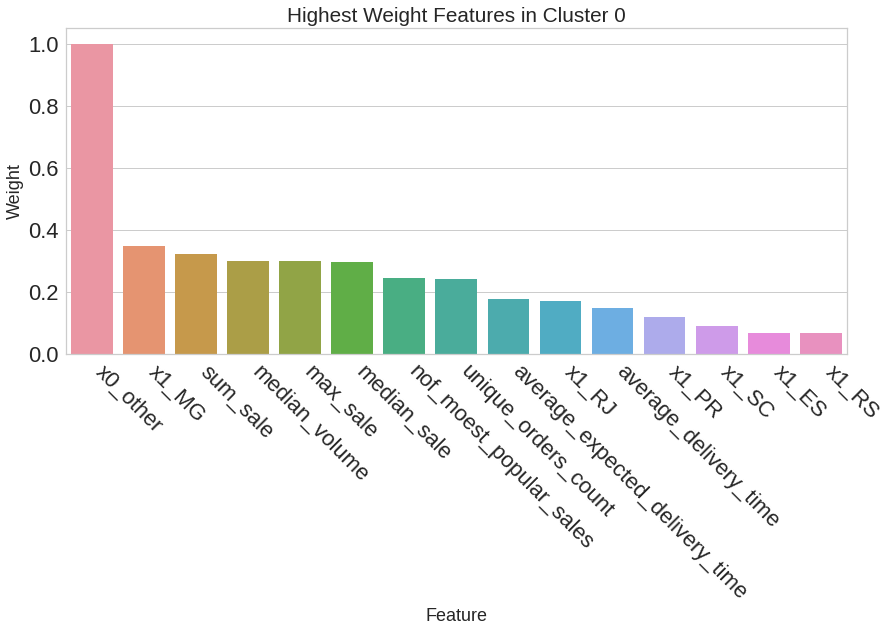

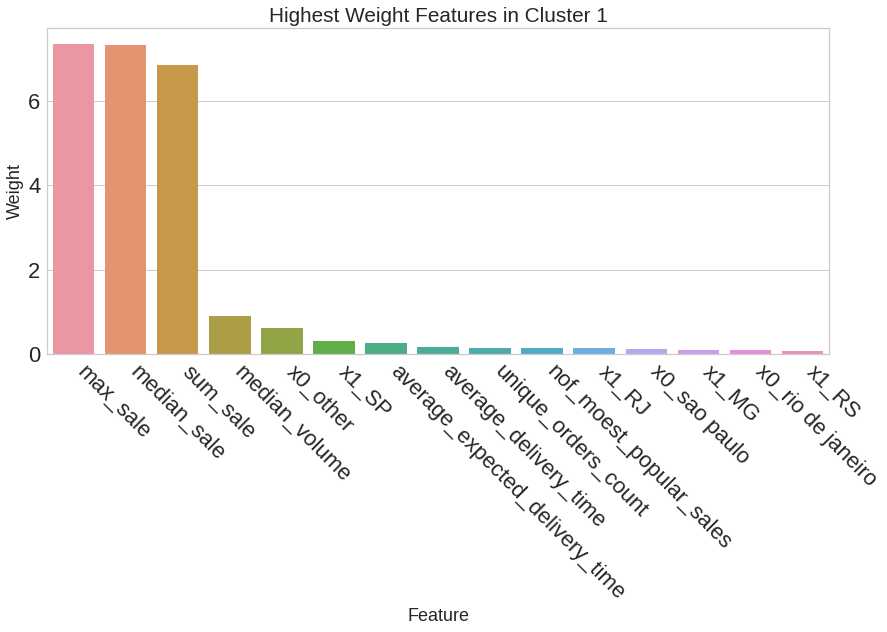

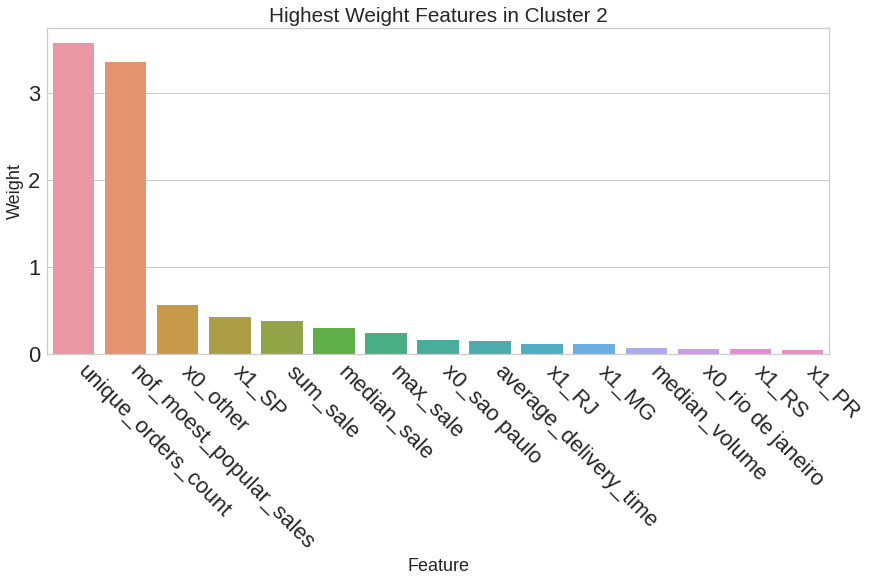

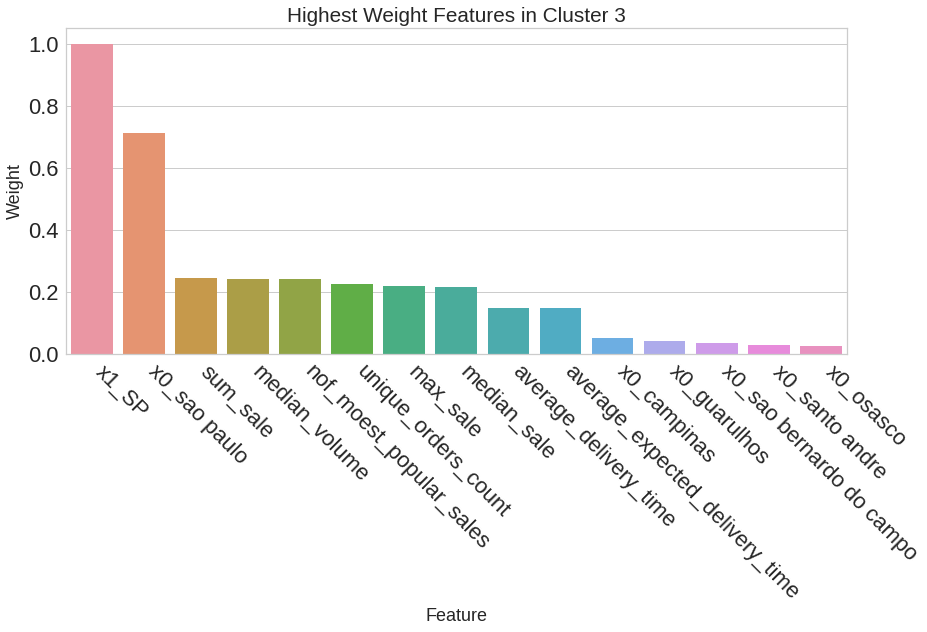

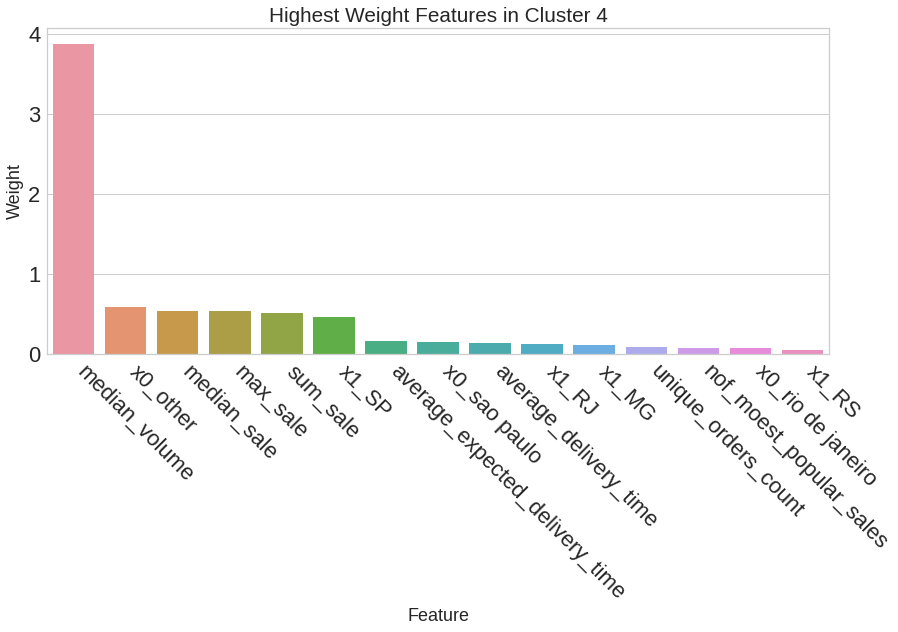

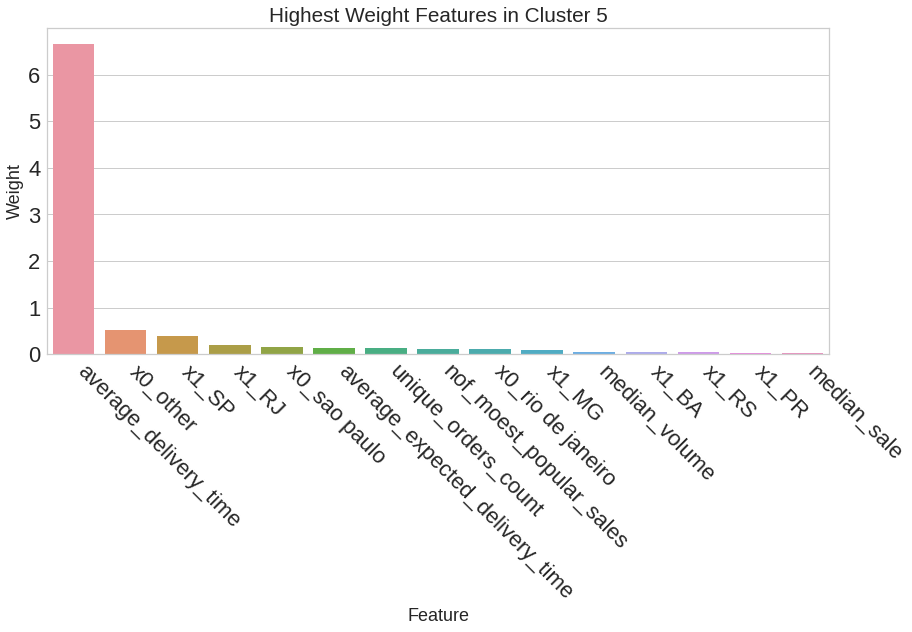

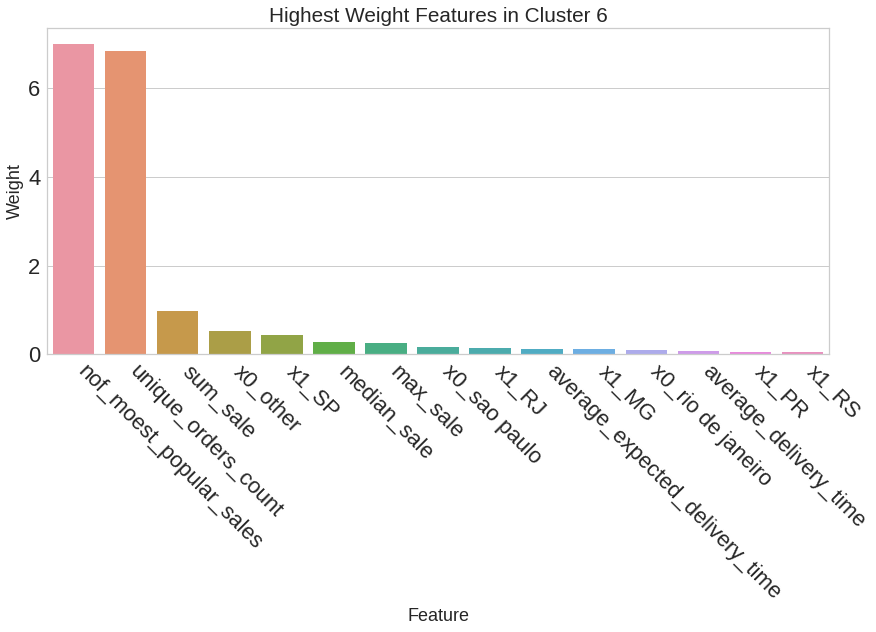

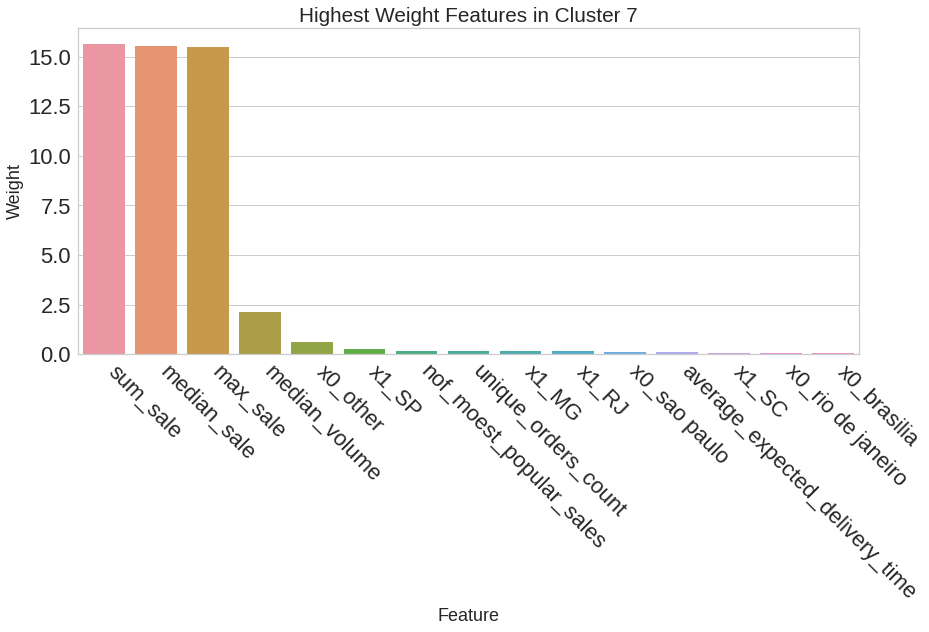

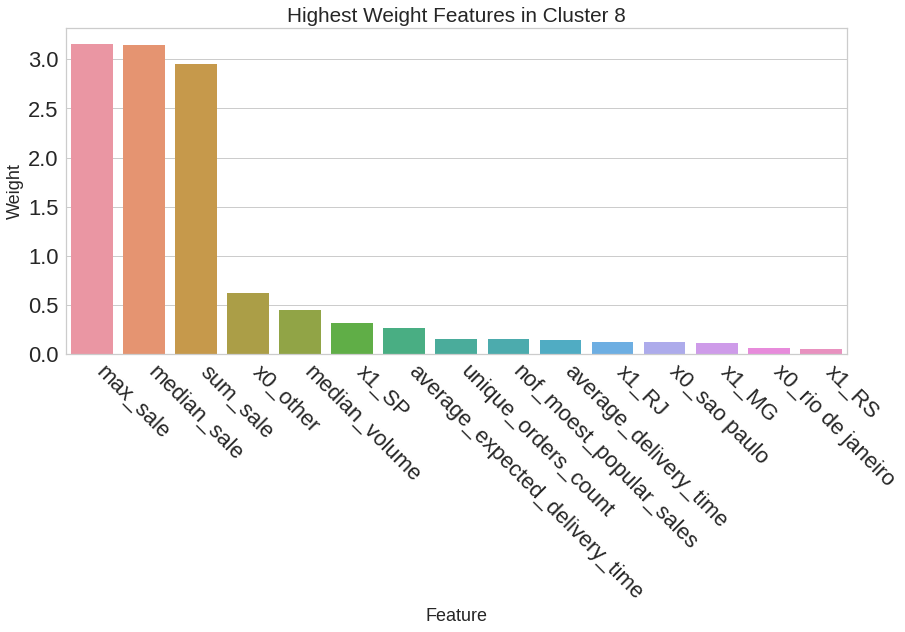

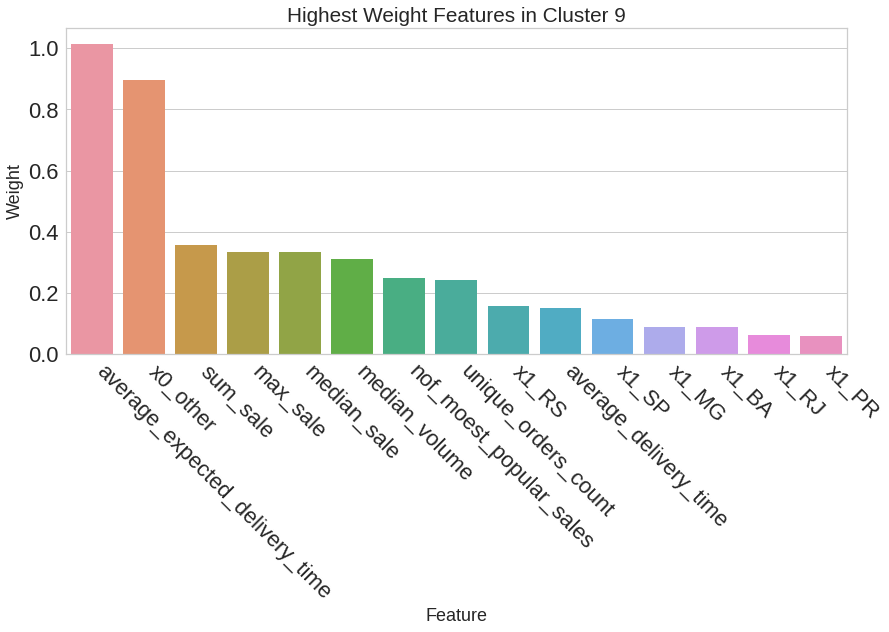

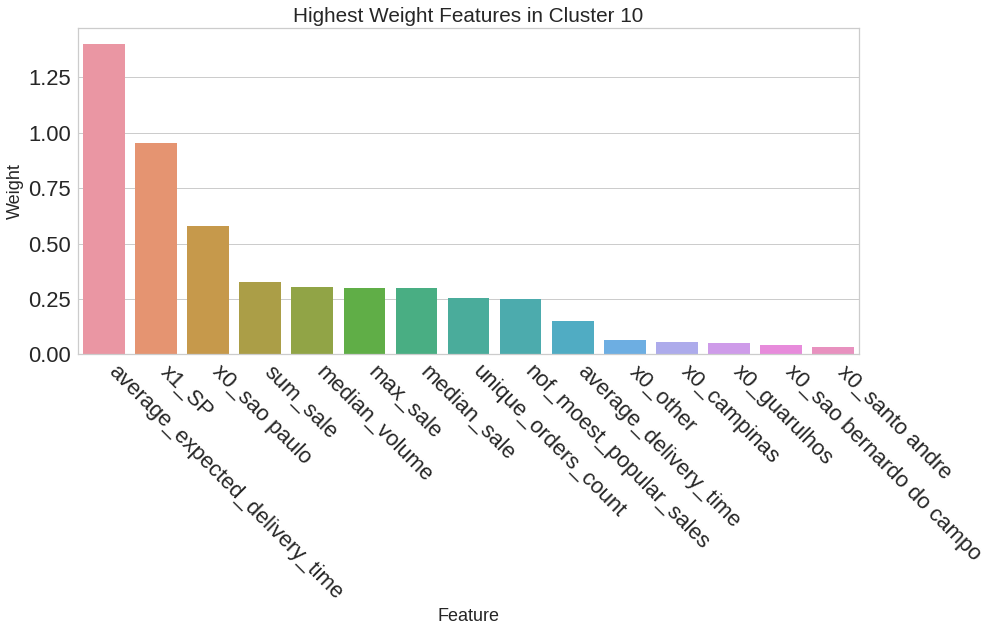

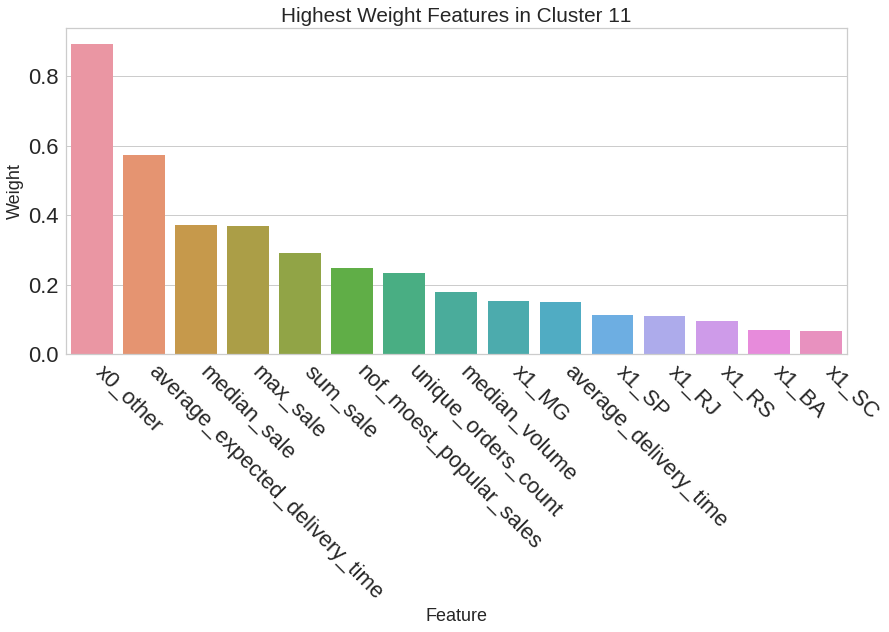

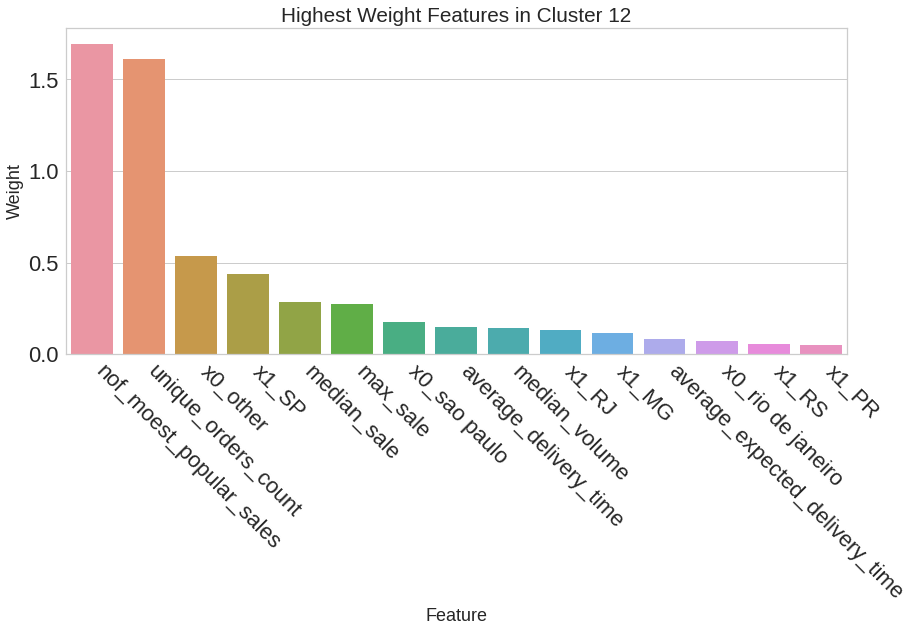

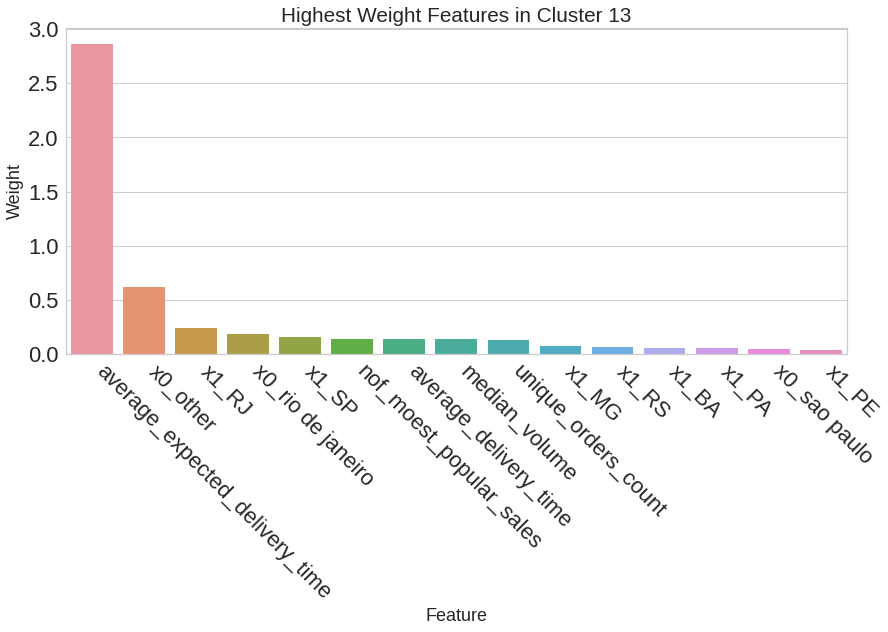

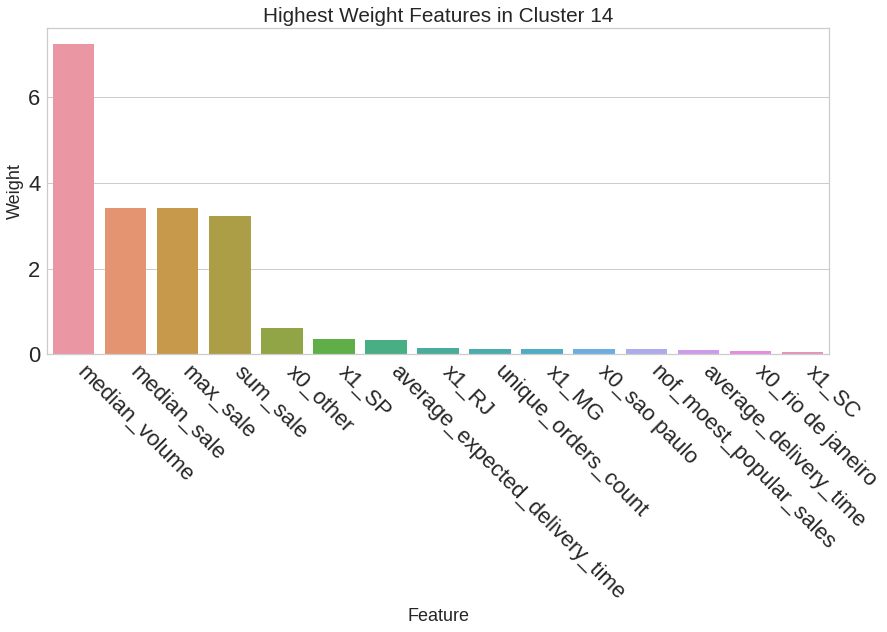

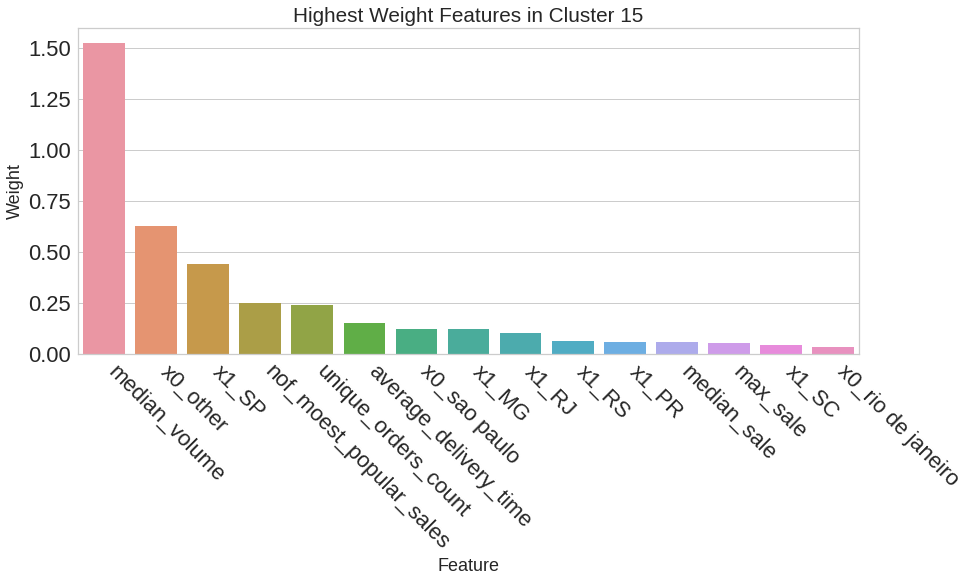

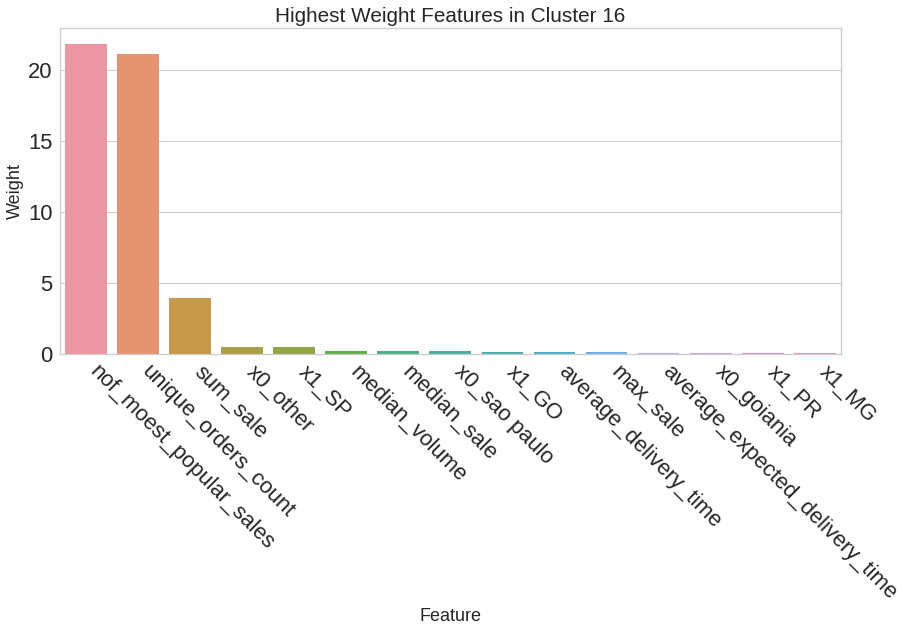

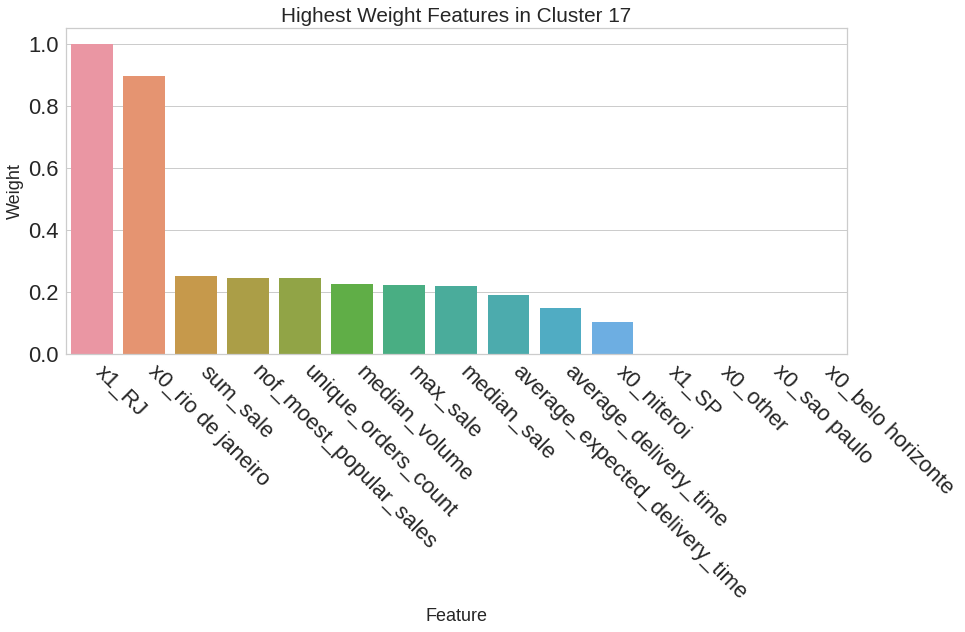

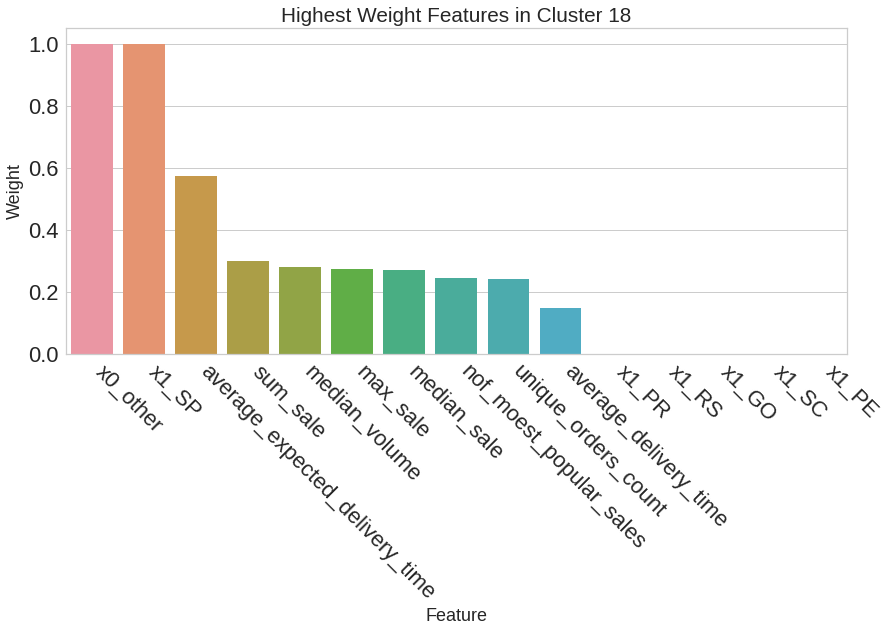

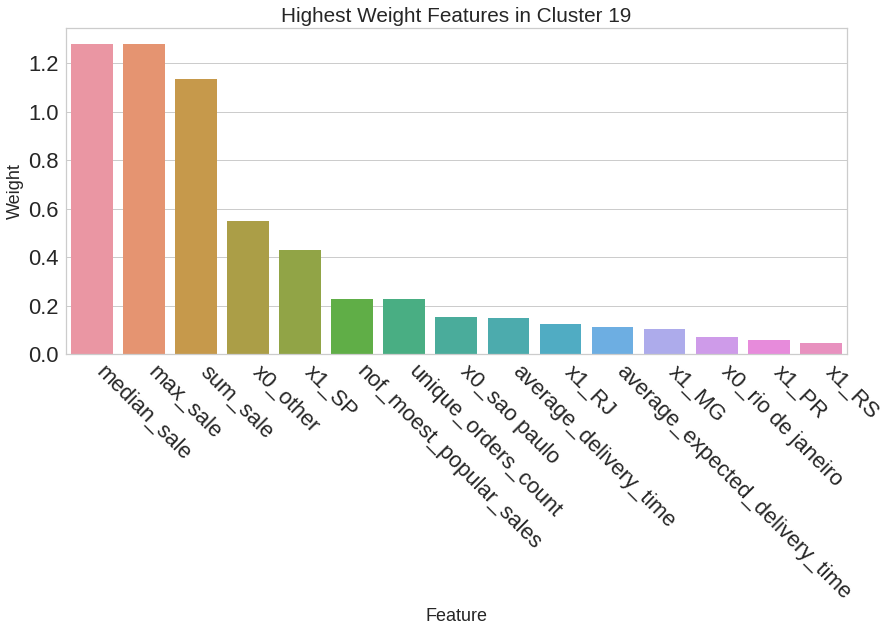

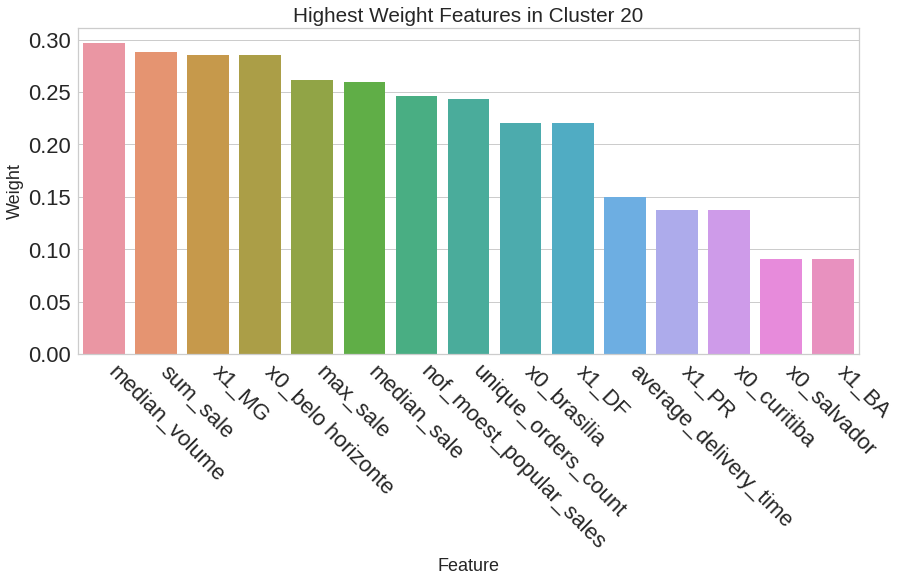

In [94]:
for cluster_label, feature_weights in interpreter.feature_importances_.items():    
    df_feature_weight = pd.DataFrame(feature_weights[:15], columns=["Feature", "Weight"])
    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left");
    ax.tick_params(axis='both', which='major', labelsize=22)
    plt.title(f'Highest Weight Features in Cluster {cluster_label}', fontsize='xx-large')
    plt.xlabel('Feature', fontsize=18)
    plt.ylabel('Weight', fontsize=18)

    plt.show();
    
    print('\n\n')

In [95]:
cols

Index(['unique_orders_count', 'nof_moest_popular_sales', 'max_sale',
       'median_sale', 'sum_sale', 'median_volume', 'average_delivery_time',
       'average_expected_delivery_time'],
      dtype='object')

In [102]:
df2.loc[df2["cluster"] == 2,"max_sale"].to_numpy()

array([59.9, 49.9, 24.9, ...,  6.9, 35. , 49. ])

In [132]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y',
       'outlier', 'cluster'],
      dtype='object')

<AxesSubplot:ylabel='Count'>

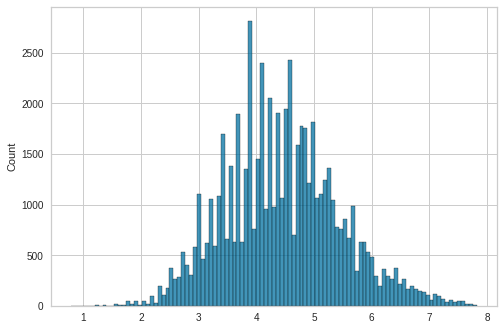

In [214]:
sns.histplot(np.log(df2.loc[~df2["cluster"].isin([17,18,0,7,13,15,]),"max_sale"].to_numpy()))

<AxesSubplot:ylabel='Count'>

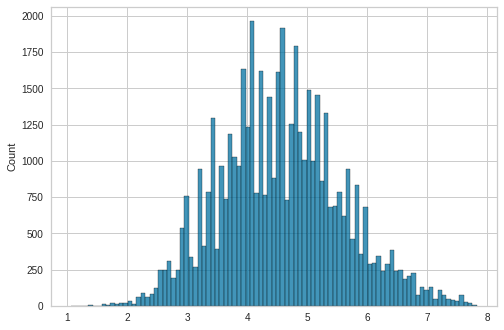

In [232]:
sns.histplot(np.log(df2.loc[~df2["cluster"].isin([5,6,16,17,18,0,7,13,15,10]),"max_sale"].to_numpy()))

<AxesSubplot:ylabel='Count'>

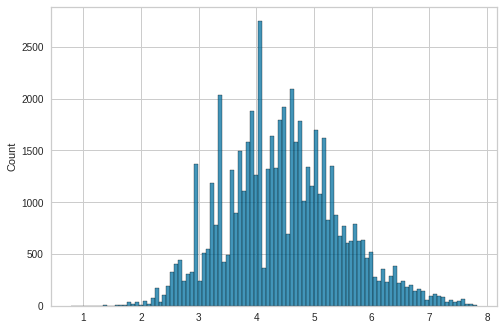

In [231]:
sns.histplot(np.log(df2.loc[~df2["cluster"].isin([5,6,16,17,18,0,7,13,15]),"max_sale"].to_numpy()))

In [114]:
from scipy.stats import kstest

In [146]:
for i in range(0,21):
    data = np.log(df2.loc[df2["cluster"] == i,"max_sale"].to_numpy())
    mean = np.mean(data)
    std = np.std(data)
    if kstest((data-mean)/std, 'norm').pvalue > 0.05 :
        print(kstest((data-mean)/std, 'norm').pvalue)
        print(i)

0.2964482996398481
5
0.5658350740840601
6
0.4830518375829337
16


In [124]:
for i in range(0,21):
    data = df2.loc[df2["cluster"] == i,"max_sale"].to_numpy()
    mean = np.mean(data)
    std = np.std(data)
    if kstest((data-mean)/std, 'norm').pvalue > 0.05 :
        print(i)

16


<AxesSubplot:xlabel='max_sale', ylabel='Count'>

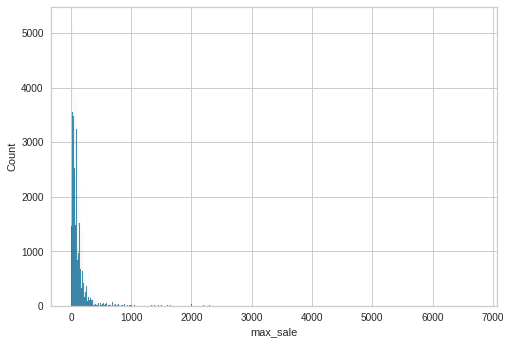

In [129]:
sns.histplot(df2["max_sale"])